# Gradient Boosting Classifier Model
---
The model in this notebook was strongly influenced by Natural Chan.  The following gradient boosted classifier will be used in an ordinal regression dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score

import time

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# from kappa_score import qwkappa

In [3]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_output_path = os.path.join(os.getcwd(),'grad boost output')
os.makedirs(gb_output_path, exist_ok = True)

In [5]:
# Split the data into training and testing sets
X_train = orig_train.drop('quality', axis=1)
y_train = orig_train['quality'].copy()
X_test = orig_test.copy()
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

# Investigate Gradient Boosted Model Parameters
Using the parameters from the best model search, investigate stratify and AUC ROC

In [6]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_solo = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_solo = {
    'n_estimators': [400],
    'learning_rate': [0.01],
    'max_depth': [2]
}

# Perform grid search with cross-validation
start_time = time.time()
grid_search_solo = GridSearchCV(model_solo, param_grid_solo, cv=5, verbose=3)
grid_search_solo.fit(X_train, y_train)

# Get the best model from grid search
best_gb_solo = grid_search_solo.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred_solo = best_gb_solo.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time

print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=400;, score=0.578 total time=   5.7s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=400;, score=0.571 total time=   5.4s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=400;, score=0.596 total time=   5.4s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=400;, score=0.608 total time=   5.4s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=400;, score=0.601 total time=   5.4s
Time to complete Grid Search: 33.508103 seconds
Time to complete prediction: 0.012764 seconds
Total time to complete Grid Search and prediction: 33.520867 seconds


In [7]:
# Calculate metrics
accuracy_solo = accuracy_score(y_val, y_pred_solo)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_solo = f1_score(y_val, y_pred_solo, average= 'weighted')
precision_solo = precision_score(y_val, y_pred_solo, average= 'weighted')
recall_solo = recall_score(y_val, y_pred_solo, average= 'weighted')
kappa_solo = cohen_kappa_score(y_val, y_pred_solo, weights='quadratic')

print(f"Third model scores:")
print("-------------------")
print(f"Best Estimators: {best_gb_solo.n_estimators}")
print(f"Best Learning Rate: {best_gb_solo.learning_rate}")
print(f"Best Max Depth: {best_gb_solo.max_depth}")
print(f"Accuracy: {accuracy_solo:.2f}")
print(f"F1: {f1_solo:.2f}")
print(f"Precision: {precision_solo:.2f}")
print(f"Recall: {recall_solo:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa_solo:.4f}")

Third model scores:
-------------------
Best Estimators: 400
Best Learning Rate: 0.01
Best Max Depth: 2
Accuracy: 0.61
F1: 0.59
Precision: 0.60
Recall: 0.61
Cohen Kappa Score, quadratic weighted: 0.4962


### Using the best parameters reported from the XGB Classifier Model
Using the Gradient Boosting Classifier, input the same parameters from the best model outcome using the XGB Classifier to compare the time difference and kappa score

In [13]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_xb = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_xb = {
    'n_estimators': [40],
    'learning_rate': [0.1],
    'max_depth': [2]
}

# Perform grid search with cross-validation
start_time = time.time()
grid_search_xb = GridSearchCV(model_xb, param_grid_xb, cv=5, verbose=3)
grid_search_xb.fit(X_train, y_train)

# Get the best model from grid search
best_xb_solo = grid_search_xb.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred_xb = best_xb_solo.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time

print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=40;, score=0.578 total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=40;, score=0.571 total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=40;, score=0.593 total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=40;, score=0.605 total time=   0.6s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=40;, score=0.604 total time=   0.5s
Time to complete Grid Search: 3.436040 seconds
Time to complete prediction: 0.002615 seconds
Total time to complete Grid Search and prediction: 3.438655 seconds


### Analysis
Using the same parameters found from the XGB Classifier model is 10 times faster than the best parameters

In [14]:
# Calculate metrics
accuracy_xb = accuracy_score(y_val, y_pred_xb)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_xb = f1_score(y_val, y_pred_xb, average= 'weighted')
precision_xb = precision_score(y_val, y_pred_xb, average= 'weighted')
recall_xb = recall_score(y_val, y_pred_xb, average= 'weighted')
kappa_xb = cohen_kappa_score(y_val, y_pred_xb, weights='quadratic')

print(f"XGB parameters used with Gradient Boosted Classifier model scores:")
print("-------------------")
print(f"Best Estimators: {best_xb_solo.n_estimators}")
print(f"Best Learning Rate: {best_xb_solo.learning_rate}")
print(f"Best Max Depth: {best_xb_solo.max_depth}")
print(f"Accuracy: {accuracy_xb:.2f}")
print(f"F1: {f1_xb:.2f}")
print(f"Precision: {precision_xb:.2f}")
print(f"Recall: {recall_xb:.2f}")
print(f"Cohen Kappa Score, quadratic weighted: {kappa_xb:.4f}")

XGB parameters used with Gradient Boosted Classifier model scores:
-------------------
Best Estimators: 40
Best Learning Rate: 0.1
Best Max Depth: 2
Accuracy: 0.60
F1: 0.59
Precision: 0.60
Recall: 0.60
Cohen Kappa Score, quadratic weighted: 0.5050


# Classification Reports

In [19]:
print("--------------------------------------------------------")

best_hp_solo = grid_search_solo.best_params_
print(f"Best Hyperparameters From the Second Round Grad Boost Model Search ")
print(f"     Learning Rate =   {best_hp_solo['learning_rate']}")
print(f"     Number of Trees = {best_hp_solo['n_estimators']}")
print(f"     Max Tree Depth =  {best_hp_solo['max_depth']}")
print()
print("--------------------------------------------------------")
print(f"Second Round Grad Boosted Model Classification Report")
print(classification_report(y_val,y_pred_solo))
print()
print("--------------------------------------------------------")
print()
print(f"Second Round Grad Boosted Quadratic Weighted Kappa Score: {kappa_solo:.4f}")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Best Hyperparameters From the Second Round Grad Boost Model Search 
     Learning Rate =   0.01
     Number of Trees = 400
     Max Tree Depth =  2

--------------------------------------------------------
Second Round Grad Boosted Model Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.67      0.73      0.70       169
           6       0.54      0.65      0.59       158
           7       0.70      0.38      0.49        69
           8       0.00      0.00      0.00         6

    accuracy                           0.61       412
   macro avg       0.32      0.29      0.30       412
weighted avg       0.60      0.61      0.59       412


--------------------------------------------------------

Second Round Grad Boosted Quadratic Weighted Kappa Score: 0.4962

---------------

In [20]:
print("--------------------------------------------------------")

best_hp_xb = grid_search_xb.best_params_
print(f"Best Hyperparameters From the Second Round Grad Boost Model Search ")
print(f"     Learning Rate =   {best_hp_xb['learning_rate']}")
print(f"     Number of Trees = {best_hp_xb['n_estimators']}")
print(f"     Max Tree Depth =  {best_hp_xb['max_depth']}")
print()
print("--------------------------------------------------------")
print(f"Second Round Grad Boosted Model Classification Report")
print(classification_report(y_val,y_pred_xb))
print()
print("--------------------------------------------------------")
print()
print(f"Second Round Grad Boosted Quadratic Weighted Kappa Score: {kappa_xb:.4f}")
print()
print("--------------------------------------------------------")

--------------------------------------------------------
Best Hyperparameters From the Second Round Grad Boost Model Search 
     Learning Rate =   0.1
     Number of Trees = 40
     Max Tree Depth =  2

--------------------------------------------------------
Second Round Grad Boosted Model Classification Report
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.67      0.73      0.70       169
           6       0.53      0.63      0.58       158
           7       0.64      0.36      0.46        69
           8       1.00      0.17      0.29         6

    accuracy                           0.60       412
   macro avg       0.47      0.31      0.34       412
weighted avg       0.60      0.60      0.59       412


--------------------------------------------------------

Second Round Grad Boosted Quadratic Weighted Kappa Score: 0.5050

-----------------

# Confusion Matrix

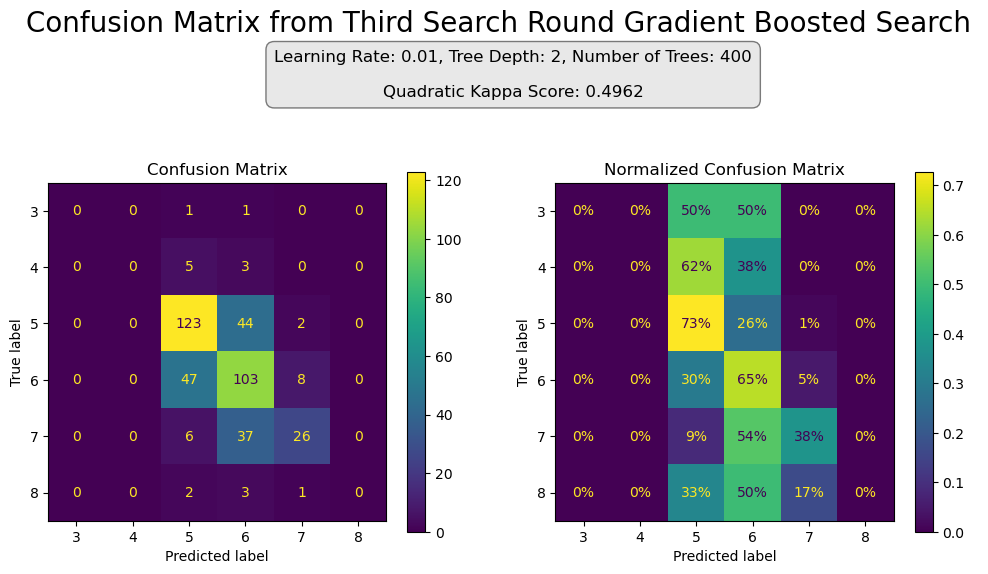

In [21]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,6))
grid_spec = GridSpec(2, 2, figure=fig, width_ratios = [3,3], height_ratios=[1, 6])

# Model specs subplot
model_specs =  f"Learning Rate: {best_gb_solo.learning_rate}, Tree Depth: {best_gb_solo.max_depth}, Number of Trees: {best_gb_solo.n_estimators}\n\nQuadratic Kappa Score: {kappa_solo:.4f}"   
upper_ax = fig.add_subplot(grid_spec[0, :])

# plt.upper_ax_adjust(hspace = 0.5)
upper_text = upper_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
upper_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_solo, ax=fig.add_subplot(grid_spec[1, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_solo,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[1, 1]))
normalized_conf_matrix_display.ax_.set_title("Normalized Confusion Matrix")


# Adjust Layout
plt.tight_layout
plt.suptitle("Confusion Matrix from Third Search Round Gradient Boosted Search", fontsize=20)

# Save and show the figure
# output_filename = f"{gb_output_path}/gb_3rd_model_kappa={kappa_3:.4f}_confusion_matrix.png" # Already saved the file from another notebook.  
# plt.savefig(output_filename)
plt.show()

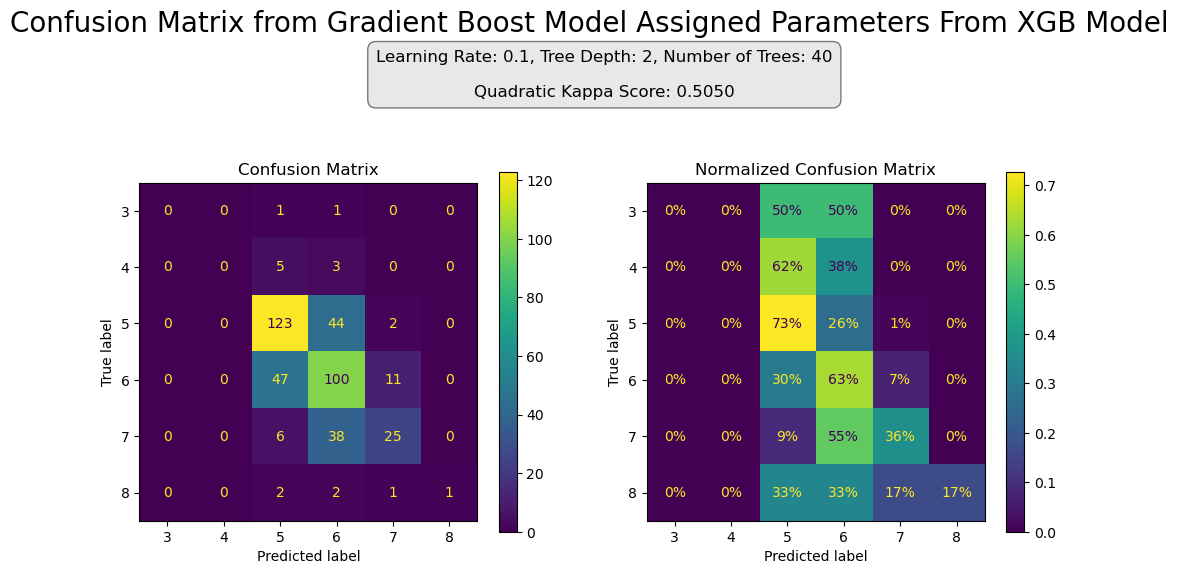

In [23]:
# Create the figure and gridspec for the model assigned the parameters from the XGB model
fig = plt.figure(figsize = (12,6))
grid_spec = GridSpec(2, 2, figure=fig, width_ratios = [3,3], height_ratios=[1, 6])

# Model specs subplot
model_specs =  f"Learning Rate: {best_xb_solo.learning_rate}, Tree Depth: {best_xb_solo.max_depth}, Number of Trees: {best_xb_solo.n_estimators}\n\nQuadratic Kappa Score: {kappa_xb:.4f}"   
upper_ax = fig.add_subplot(grid_spec[0, :])

# plt.upper_ax_adjust(hspace = 0.5)
upper_text = upper_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
upper_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_xb, ax=fig.add_subplot(grid_spec[1, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_xb,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[1, 1]))
normalized_conf_matrix_display.ax_.set_title("Normalized Confusion Matrix")


# Adjust Layout
plt.tight_layout
plt.suptitle("Confusion Matrix from Gradient Boost Model Assigned Parameters From XGB Model", fontsize=20)

# Save and show the figure
output_filename = f"{gb_output_path}/gb_with-XGB-params_model_kappa={kappa_xb:.4f}_confusion_matrix.png"
plt.savefig(output_filename)
plt.show()

# ROC AUC and ROC OvR / OvO Curves

In [39]:
list(y_train.unique())

[5, 6, 7, 4, 8, 3]

In [40]:
# https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
quality_combinations = []
quality_list = list(y_train.unique())
for i in range(len(quality_list)):
    for j in range (i+1, len(quality_list)):
        quality_combinations.append([quality_list[i], quality_list[j]])
        quality_combinations.append([quality_list[j], quality_list[i]])


In [49]:
# Predict class probabilities on the test data
y_proba = best_gb_solo.predict_proba(X_val)
y = pd.DataFrame(y_train.unique())
y

,0
0,5
1,6
2,7
3,4
4,8
5,3


In [54]:

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = list(y_train.unique()) # model_solo.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    q = quality_list[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == q else 0 for q in y_val]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(q)
    ax.legend([f"Class: {q}", "Rest"])
    ax.set_xlabel(f"P(x = {q})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[q] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1200x800 with 0 Axes>

NameError: name 'get_all_roc_coordinates' is not defined

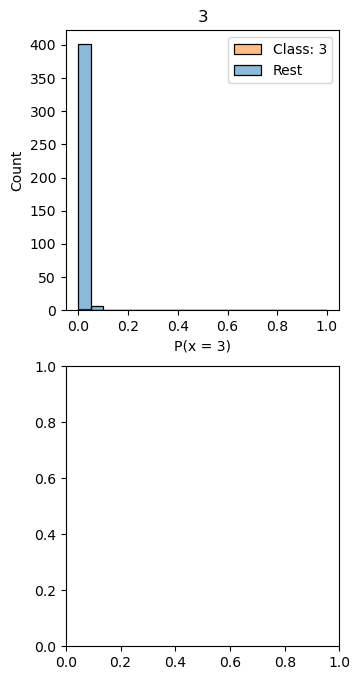

In [55]:
# Get unique classes from y_train
quality_list = np.unique(y_train)

# Create combinations of quality pairs
quality_combinations = []
for i in range(len(quality_list)):
    for j in range(i + 1, len(quality_list)):
        quality_combinations.append([quality_list[i], quality_list[j]])
        quality_combinations.append([quality_list[j], quality_list[i]])

# Predict class probabilities on the validation data
y_proba = best_gb_solo.predict_proba(X_val)

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize=(12, 8))
bins = [i / 20 for i in range(21)]  # Fixed bins
roc_auc_ovr = {}

for i, q in enumerate(quality_list):
    # Prepare an auxiliary DataFrame to help with the plots
    df_aux = X_val.copy()
    df_aux['class'] = [1 if y == q else 0 for y in y_val]
    df_aux['prob'] = y_proba[:, i]
    
    # Plot the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i + 1)
    sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, bins=bins)
    ax.set_title(q)
    ax.legend([f"Class: {q}", "Rest"])
    ax.set_xlabel(f"P(x = {q})")
    
    # Calculate the ROC Coordinates and plot the ROC Curves
    ax_bottom = plt.subplot(2, 3, i + 4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter=False, ax=ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculate the ROC AUC OvR
    roc_auc_ovr[q] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()
plt.show()


In [ ]:
# Plots the Probability Distributions and the ROC Curves One vs One
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}
for i in range(len(classes_combinations)):
    # Gets the class
    comb = quality_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = quality_list.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_val
    df_aux['prob'] = y_pred_solo[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()